In [165]:
import pandas as pd
import openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False ## 마이나스 '-' 표시 제대로 출력
 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [166]:
# 한글 폰트
import matplotlib.font_manager
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
print([matplotlib.font_manager.FontProperties(fname=font).get_name() for font in font_list if 'Nanum' in font][:10])
plt.rcParams["font.family"] = 'NanumSquareRound'
plt.rcParams["figure.figsize"] = (10,5)

['NanumSquareOTF_ac', 'NanumSquareRound', 'NanumSquareOTF', 'NanumSquareOTF_ac', 'NanumSquareOTF_ac', 'NanumBarunGothic', 'NanumSquare_ac', 'NanumSquareOTF_ac', 'NanumSquareOTF', 'NanumGothic']


In [167]:
# get Data file
file_path = '../data/output/특정품목 조달 내역_2020-2022.xlsx'
data = pd.read_excel(file_path, index_col=0)
print(data.head(5))

  수요기관지역명 수요기관구분      장비금액       계약금액    냉방용량    난방용량         날짜
0     경기도    지자체   1502000    6758800    18.4    20.7 2022-01-21
1     경기도    지자체   6367000   23828260    62.9    70.9 2022-04-18
2   서울특별시    지자체   7570000   30011200    75.5    85.6 2022-01-26
3     경기도   교육기관  41502960  218391150  1054.9  1183.7 2022-02-15
4   서울특별시    지자체   3662000   30120750    47.2    52.9 2022-05-04


In [168]:
# make new columns
data['용량'] = data[['냉방용량','난방용량']].max(axis=1)

# delete the row with the 0 cost
data = data[data['계약금액'] != 0]
data = data[data['장비금액'] != 0]
data = data[data['용량'] != 0]

# make new columns
data['장비금액비율'] = data['장비금액']/data['계약금액']
data = data[data['장비금액비율'] < 0.8]


In [169]:

# calculate the lower and upper bounds based on the specified quantile value
q1 = data['용량'].quantile(0.25)
q3 = data['용량'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

In [170]:
# filter out the outlier rows
data = data[(data['용량'] >= lower_bound) & (data['용량'] <= upper_bound)]
print(data.head(5))


   수요기관지역명 수요기관구분     장비금액      계약금액  냉방용량  난방용량         날짜    용량    장비금액비율
0      경기도    지자체  1502000   6758800  18.4  20.7 2022-01-21  20.7  0.222229
1      경기도    지자체  6367000  23828260  62.9  70.9 2022-04-18  70.9  0.267204
2    서울특별시    지자체  7570000  30011200  75.5  85.6 2022-01-26  85.6  0.252239
4    서울특별시    지자체  3662000  30120750  47.2  52.9 2022-05-04  52.9  0.121577
11   서울특별시    지자체  4550000  18645680  40.8  45.7 2022-04-21  45.7  0.244024


In [ ]:
def drawLinearRegression(x , y):
    # create a linear regression model
    reg = LinearRegression().fit(x, y)

    # use statsmodels to identify influential points
    influence = sm.OLS(data['계약금액'], sm.add_constant(data['용량'])).fit().get_influence()
    outliers = influence.summary_frame().loc[influence.summary_frame().cooks_d > 4/len(data)]

    # remove the influential points from the dataframe
    data = data.drop(outliers.index)

    # re-fit the linear regression model without the influential points
    reg = LinearRegression().fit(x, y)

    # print the coefficients
    print('Intercept:', reg.intercept_)
    print('Coefficient:', reg.coef_[0])
    return reg

In [171]:
# create a linear regression model
reg = LinearRegression().fit(data[['용량']], data['계약금액'])

# use statsmodels to identify influential points
influence = sm.OLS(data['계약금액'], sm.add_constant(data['용량'])).fit().get_influence()
outliers = influence.summary_frame().loc[influence.summary_frame().cooks_d > 4/len(data)]

# remove the influential points from the dataframe
data_copy = data.drop(outliers.index)

# re-fit the linear regression model without the influential points
reg = Linearregression().fit(data_copy[['용량']], data_copy['계약금액'])

# print the coefficients
print('Intercept:', reg.intercept_)
print('Coefficient:', reg.coef_[0])

Intercept: 1426927.7060952485
Coefficient: 259070.0491751709


Text(0.5, 1.0, 'Scatter plot with linear regression line')

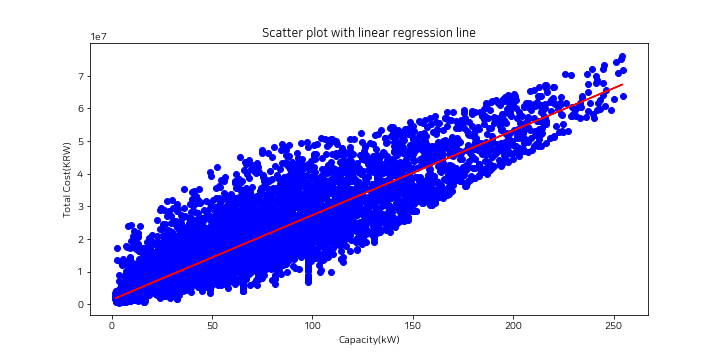

In [172]:
%matplotlib widget
# plot the scatter plot and linear regression line
fig, ax = plt.subplots()
ax.scatter(data_copy['용량'], data_copy['계약금액'], color='blue')
ax.plot(data_copy['용량'], reg.predict(data_copy[['용량']]), color='red')
ax.set_xlabel('Capacity(kW)')
ax.set_ylabel('Total Cost(KRW)')
ax.set_title('Scatter plot with linear regression line')

In [173]:
# create a linear regression model
reg = LinearRegression().fit(data[['용량']], data['장비금액비율'])

# use statsmodels to identify influential points
influence = sm.OLS(data['장비금액비율'], sm.add_constant(data['용량'])).fit().get_influence()
outliers = influence.summary_frame().loc[influence.summary_frame().cooks_d > 4/len(data)]

# remove the influential points from the dataframe
data_copy = data.drop(outliers.index)

# re-fit the linear regression model without the influential points
reg = LinearRegression().fit(data_copy[['용량']], data_copy['장비금액비율'])

# print the coefficients
print('Intercept:', reg.intercept_)
print('Coefficient:', reg.coef_[0])

Intercept: 0.246599644356919
Coefficient: 8.524359589490565e-05


Text(0.5, 1.0, 'Average Device/Total ratio')

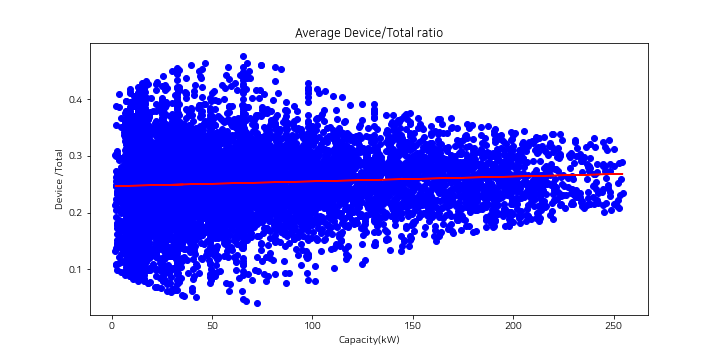

In [174]:
%matplotlib widget
# plot the scatter plot and linear regression line
fig, ax = plt.subplots()
ax.scatter(data_copy['용량'], data_copy['장비금액비율'], color='blue')
ax.plot(data_copy['용량'], reg.predict(data_copy[['용량']]), color='red')
ax.set_xlabel('Capacity(kW)')
ax.set_ylabel('Device /Total')
ax.set_title('Average Device/Total ratio')

In [175]:
# create boxplot
stats = data_copy.groupby('수요기관지역명').agg({'장비금액비율': ['mean'], '계약금액':['mean']})
print(stats)

           장비금액비율          계약금액
             mean          mean
수요기관지역명                        
강원도      0.253021  1.691105e+07
경기도      0.242464  1.909948e+07
경상남도     0.239798  1.639559e+07
경상북도     0.265729  1.491508e+07
광주광역시    0.266964  1.508955e+07
대구광역시    0.261728  1.469381e+07
대전광역시    0.264046  1.507018e+07
부산광역시    0.240444  1.835163e+07
서울특별시    0.233119  2.116005e+07
세종특별자치시  0.252065  1.680674e+07
울산광역시    0.262503  1.473591e+07
인천광역시    0.225852  2.088112e+07
전라남도     0.249756  1.672464e+07
전라북도     0.260680  1.751741e+07
제주특별자치도  0.260150  1.254774e+07
충청남도     0.264517  1.651548e+07
충청북도     0.268706  1.562280e+07
